In [1]:
import os
import os.path as osp
import configparser
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import math

In [2]:
config_path = osp.join(osp.dirname(os.getcwd()), 'config.ini')
parser = configparser.ConfigParser()
parser.read(config_path)
raw_wesad_folder_path = parser['RAW_DATA_PATH']['wesad_dataset_path']

In [3]:
def resampling(subject_id, raw_data, data_labels, TARGETED_SAMPLING_RATE: int):
    labels = ['', 'baseline', 'stress', 'amusement', 'meditation']
    # Get targeted indices for ground-truth label
    mask = np.where((data_labels < 5) & (data_labels > 0))[0]
    # Extract targeted BVP data
    ORIGIN_SAMPLING_RATE = 700
    data = {}
    filtered_data_labels = data_labels[mask]
    # Get change point index
    cp_indices = [index for index in range(1, len(mask)) if filtered_data_labels[index] != filtered_data_labels[index-1]]
    cp_indices.append(len(mask))
    ptr = 0
    for i, index in enumerate(cp_indices):
        end_ptr = mask[index-1] + 1 # End pointer of the 700Hz raw data 
        gt = list(set(data_labels[mask[ptr]:end_ptr])) # Get the session index 
        assert((len(gt) == 1) & (0 < gt[0] < 5)) # Assert that there is only one label for the task and the task label is in the range 1-4 as described in the docs
        start_mapping_index = int(round(mask[ptr] * TARGETED_SAMPLING_RATE / ORIGIN_SAMPLING_RATE)) # Beginning index of 64Hz BVP data of the targeted session 
        end_mapping_index = start_mapping_index + round((index - ptr) * TARGETED_SAMPLING_RATE / ORIGIN_SAMPLING_RATE) # Ending index of 64Hz BVP data of the targeted session
        signal_data = raw_data[start_mapping_index:end_mapping_index]
        assert(round((len(signal_data) / TARGETED_SAMPLING_RATE)) == round((index - ptr) / ORIGIN_SAMPLING_RATE)) # Assert that the mapping has the same number of items in terms of time dimension
        ptr = index # !!! ALWAYS REMEMBER TO UPDATE THE POINTER 
        session_name = f'{subject_id}_{labels[gt[0]]}_{i+1}'
        data[session_name] = pd.DataFrame(data=signal_data, columns=['nanoWatt'])
    return data

In [4]:
def load_wesad_wrist_bvp(subject_id: str, data_path: str):
    # Prepare metadata and load raw EmpaticaE4 data
    data = pickle.load(open(data_path, 'rb'), encoding='bytes')
    raw_bvp_data = data[b'signal'][b'wrist'][b'BVP']
    data_labels = data[b'label']
    bvp_data = resampling(subject_id, raw_bvp_data, data_labels, 64)
    return bvp_data

In [5]:
def load_wesad_chest_ecg(subject_id: str, data_path: str):
    data = pickle.load(open(data_path, 'rb'), encoding='bytes')
    raw_ecg_data = data[b'signal'][b'chest'][b'ECG']
    data_labels = data[b'label']
    ecg_data = resampling(subject_id, raw_ecg_data, data_labels, 700)
    return ecg_data

## Extract BVP signal data recorded by wrist-worn device Empatica E4

In [6]:
# Extract BVP signal data recorded by wrist-worn device Empatica E4
output_folder_path = osp.join(parser['DATA_PATH']['wesad_dataset_path'], 'WESAD_WRIST_BVP')
subject_ids = os.listdir(raw_wesad_folder_path)
for subject_id in tqdm(subject_ids):
    subject_output_folder = osp.join(output_folder_path, subject_id)
    if not osp.exists(subject_output_folder):
        os.makedirs(subject_output_folder)
    data_path = osp.join(raw_wesad_folder_path, subject_id, subject_id + '.pkl')
    data = load_wesad_wrist_bvp(subject_id, data_path) # Empatica E4 BVP Samling Rate = 64Hz
    for session_name, bvp_data in data.items():
        session_name += '.csv'
        output_file_path = osp.join(subject_output_folder, session_name)
        bvp_data.to_csv(output_file_path, index=False)

100%|██████████| 15/15 [00:39<00:00,  2.62s/it]


## Extract ECG signal data recorded by chest-worn device

In [7]:
output_folder_path = osp.join(parser['DATA_PATH']['wesad_dataset_path'], 'WESAD_CHEST_ECG')
subject_ids = os.listdir(raw_wesad_folder_path)
for subject_id in tqdm(subject_ids):
    subject_output_folder = osp.join(output_folder_path, subject_id)
    if not osp.exists(subject_output_folder):
        os.makedirs(subject_output_folder)
    data_path = osp.join(raw_wesad_folder_path, subject_id, subject_id + '.pkl')
    data = load_wesad_chest_ecg(subject_id, data_path) # ECG Samling Rate = 700Hz
    for session_name, ecg_data in data.items():
        session_name += '.csv'
        output_file_path = osp.join(subject_output_folder, session_name)
        ecg_data.to_csv(output_file_path, index=False)

100%|██████████| 15/15 [01:16<00:00,  5.08s/it]


## Analyze BVP data

In [8]:
import neurokit2 as nk
from scipy.stats import kurtosis, skew

In [12]:
def _hrv_get_rri(peaks = None, sampling_rate = 1000, interpolate = False, **kwargs):
    rri = np.diff(peaks) / sampling_rate * 1000
    if interpolate is False:
        return rri
    else:
        # Minimum sampling rate for interpolation
        if sampling_rate < 10:
            sampling_rate = 10
        # Compute length of interpolated heart period signal at requested sampling rate.
        desired_length = int(np.rint(peaks[-1]))
        rri = nk.signal_interpolate(
            peaks[1:],  # Skip first peak since it has no corresponding element in heart_period
            rri,
            x_new=np.arange(desired_length),
            **kwargs
        )
        return rri, sampling_rate

In [58]:
def _hrv_sanitize_input(peaks=None):

    if isinstance(peaks, tuple):
        peaks = _hrv_sanitize_tuple(peaks)
    elif isinstance(peaks, (dict, pd.DataFrame)):
        peaks = _hrv_sanitize_dict_or_df(peaks)
    else:
        peaks = _hrv_sanitize_peaks(peaks)

    return peaks


# =============================================================================
# Internals
# =============================================================================
def _hrv_sanitize_tuple(peaks):

    # Get sampling rate
    info = [i for i in peaks if isinstance(i, dict)]
    sampling_rate = info[0]['sampling_rate']

    # Get peaks
    if isinstance(peaks[0], (dict, pd.DataFrame)):
        try:
            peaks = _hrv_sanitize_dict_or_df(peaks[0])
        except NameError:
            if isinstance(peaks[1], (dict, pd.DataFrame)):
                try:
                    peaks = _hrv_sanitize_dict_or_df(peaks[1])
                except NameError:
                    peaks = _hrv_sanitize_peaks(peaks[1])
            else:
                peaks = _hrv_sanitize_peaks(peaks[0])

    return peaks, sampling_rate


def _hrv_sanitize_dict_or_df(peaks):

    # Get columns
    if isinstance(peaks, dict):
        cols = np.array(list(peaks.keys()))
        if 'sampling_rate' in cols:
            sampling_rate = peaks['sampling_rate']
        else:
            sampling_rate = None
    elif isinstance(peaks, pd.DataFrame):
        cols = peaks.columns.values
        sampling_rate = None

    cols = cols[["Peak" in s for s in cols]]

    if len(cols) > 1:
        cols = cols[[("ECG" in s) or ("PPG" in s) for s in cols]]

    if len(cols) == 0:
        raise NameError(
            "NeuroKit error: hrv(): Wrong input, ",
            "we couldn't extract R-peak indices. ",
            "You need to provide a list of R-peak indices.",
        )

    peaks = _hrv_sanitize_peaks(peaks[cols[0]])

    if sampling_rate is not None:
        return peaks, sampling_rate
    else:
        return peaks


def _hrv_sanitize_peaks(peaks):

    if isinstance(peaks, pd.Series):
        peaks = peaks.values

    if len(np.unique(peaks)) == 2:
        if np.all(np.unique(peaks) == np.array([0, 1])):
            peaks = np.where(peaks == 1)[0]

    if isinstance(peaks, list):
        peaks = np.array(peaks)

    return peaks

In [102]:
def extract_bvp_features(bvp_data, sampling_rate):
    # Extract Heart Rate, RR Interval, and Heart Rate Variability features from PPG signals
    ppg_signals, info = nk.ppg_process(bvp_data, sampling_rate = sampling_rate)
    hr = ppg_signals['PPG_Rate']
    peaks = info['PPG_Peaks']

    # Sanitize input
    peaks = _hrv_sanitize_input(peaks)
    if isinstance(peaks, tuple):  # Detect actual sampling rate
        peaks, sampling_rate = peaks[0], peaks[1]
    rri = _hrv_get_rri(peaks, sampling_rate = sampling_rate, interpolate = False)
    diff_rri = np.diff(rri)
    hrv_times = nk.hrv_time(peaks, sampling_rate = sampling_rate)
    hrv_features = nk.hrv(peaks, sampling_rate = sampling_rate) # Ignore NeuroKitWarning: The duration of recording is too short to support a sufficiently long window for high frequency resolution as we used another frequency for hrv_frequency
    hrv_frequency = nk.hrv_frequency(peaks, sampling_rate = sampling_rate, ulf = (0.01, 0.04), lf = (0.04, 0.15), hf = (0.15, 0.4), show=True) # the parameters of ULF, LF, HF follows the original paper of WESAD dataset
    
    # Philip Schmidt, Attila Reiss, Robert Duerichen, Claus Marberger, and Kristof Van Laerhoven. 2018. Introducing WESAD, a Multimodal Dataset for Wearable Stress and Affect Detection.
    # In Proceedings of the 20th ACM International Conference on Multimodal Interaction (ICMI '18). Association for Computing Machinery, New York, NY, USA, 400–408. DOI:https://doi.org/10.1145/3242969.3242985
    # Not including: f_x_HRV of ULF and HLF, rel_f_x, sum f_x_HRV
    mean_HR, std_HR = np.mean(hr), np.std(hr)
    mean_HRV, std_HRV = hrv_features['HRV_MeanNN'], hrv_features['HRV_SDNN']
    HRV_ULF, HRV_LF, HRV_HF, HRV_LFHF, HRV_LFnorm, HRV_HFnorm = hrv_frequency['HRV_ULF'], hrv_frequency['HRV_LF'], hrv_frequency['HRV_HF'], hrv_frequency['HRV_LFHF'], hrv_frequency['HRV_LFn'], hrv_frequency['HRV_HFn']
    nn50 = np.sum(np.abs(diff_rri) > 50)
    HRV_TINN, HRV_pNN50, HRV_RMSSD = hrv_features['HRV_TINN'], hrv_features['HRV_pNN50'], hrv_features['HRV_RMSSD']

    # Nkurikiyeyezu, K., Yokokubo, A., & Lopez, G. (2019). The Influence of Person-Specific Biometrics in Improving Generic Stress Predictive Models. 
    # ArXiv, abs/1910.01770.
    kurtosis_HRV, skewness_HRV = kurtosis(rri), skew(rri)
    HRV_VLF = hrv_frequency['HRV_VLF']
    HRV_SD1, HRV_SD2 = hrv_features['HRV_SD1'], hrv_features['HRV_SD2']
    HRV_SDRR_RMSSD = std_HRV / HRV_RMSSD
    adj_sum_rri = diff_rri + 2 * rri[:-1]
    HRV_pNN25 = np.sum(np.abs(diff_rri) > 25) / len(rri) * 100
    relative_RRI = 2 * diff_rri / adj_sum_rri
    mean_relativeRRI, median_relativeRRI, std_relativeRRI, RMSSD_relativeRRI, kurtosis_relativeRRI, skew_relativeRRI = np.mean(relative_RRI), np.median(relative_RRI), np.std(relative_RRI), np.sqrt(np.mean(np.diff(relative_RRI) ** 2)), kurtosis(relative_RRI), skew(relative_RRI)

    # Combining the extracted features
    features = [mean_HR, std_HR, mean_HRV, std_HRV, kurtosis_HRV, skewness_HRV, nn50, HRV_pNN50, HRV_pNN25, HRV_TINN, HRV_RMSSD, HRV_LF, HRV_HF, HRV_LFHF, HRV_LFnorm, HRV_HFnorm, HRV_SD1, HRV_SD2, HRV_SDRR_RMSSD, mean_relativeRRI, median_relativeRRI, std_relativeRRI, RMSSD_relativeRRI, kurtosis_relativeRRI, skew_relativeRRI]
    features = np.array(list(map(float, features)))
    return features


  0%|          | 0/15 [00:00<?, ?it/s]

241.87867465283415
0.025767684231468507
236.90045625087976
0.01090874152929603
226.96230926442905
0.021474590545968023
242.93785333811684
0.02898696621807042
264.7872156267226
0.03543200163766254
254.85326815026428
0.029965553804294918
235.3392002530064
0.04620189692475163
194.19560973519853
0.047249035811357816
174.89936744423738
0.049667701672078034
174.47805614429817
0.025832087495645802
191.6666051315276
0.030418507198397286
205.42991722934892
0.057036370055330694
205.46877091924063
0.06257588878766174
209.04008544009972
0.05323480266814468
208.59954016202877
0.05597053551392521
172.5689265734312
0.01940548652058593
149.12123231479592
0.02252347172446692
140.86592016977625
0.021186828933503925
151.88404613331707
0.016412228388750085
171.09890276360548
0.022758052236423167
193.1354965900972
0.022337264624163772


/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()


216.54911916914148
0.019202769381476255
221.65178183863395
0.02137470168096634


/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()


226.1486076560173
0.05130405612932865
236.48971563828854
0.06093966214358486


/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

223.66176966991796
0.05188571009186323
221.98200125324504
0.04207660441270193
214.57750713210595
0.027733910096824202


/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

216.18098477836696
0.033455800364127854
212.40135645194863
0.04446525575234237


/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

225.48037739184338
0.05379962564931445
238.71658157307544
0.05239906810966094
258.8943062391631
0.025053099281076376


/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

286.74630915003985
0.021364415278300176
298.9037196971085
0.016974119559922663
271.7044551705162
0.018323390234970198


/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

269.89296477216783
0.017625427921308418
272.29230762592897
0.037751442823465146
264.50610969174335
0.03137837873859722


/home/nmduy/anaconda3/lib/python3.8/site-packages/neurokit2/hrv/hrv_frequency.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  __, ax = plt.subplots()
/home/nmduy/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
  0%|          | 0/15 [00:04<?, ?it/s]

225.13165621125933
0.049527515049409776


KeyboardInterrupt: 

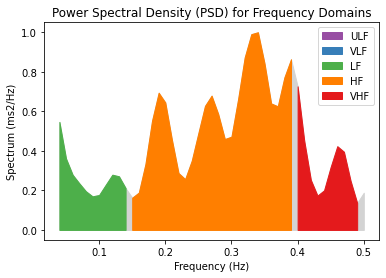

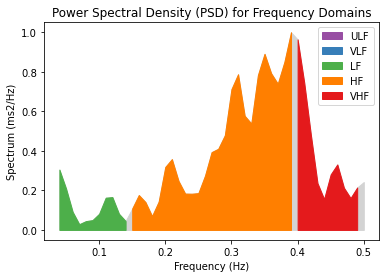

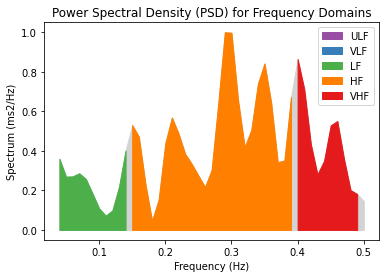

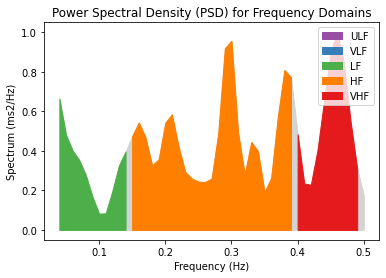

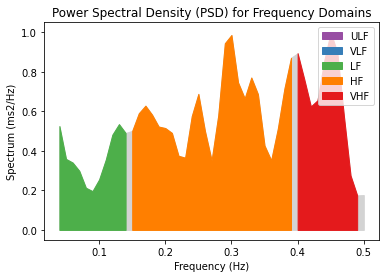

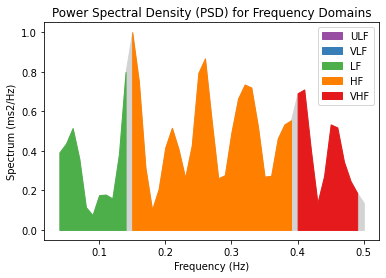

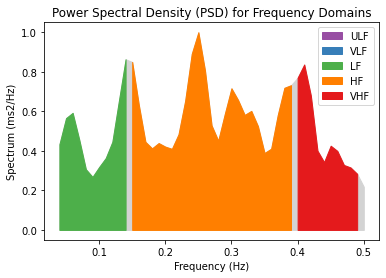

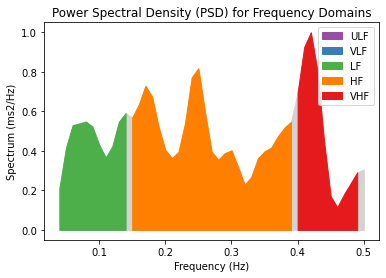

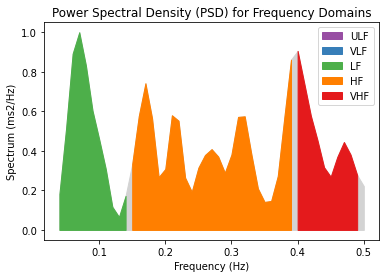

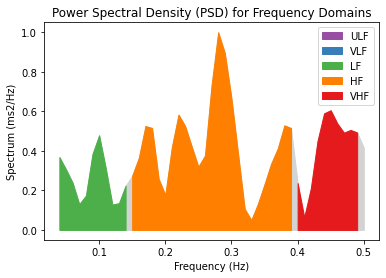

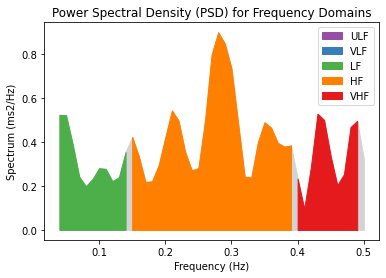

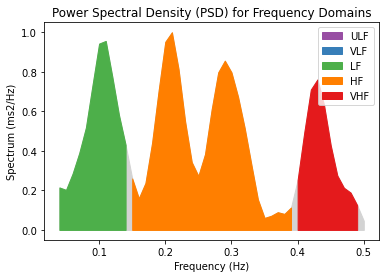

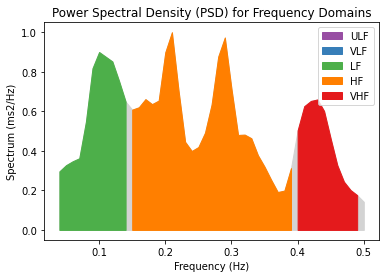

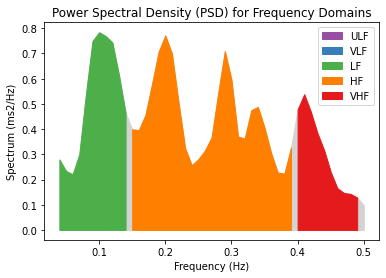

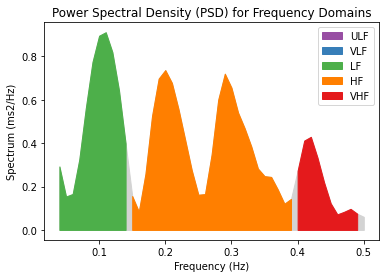

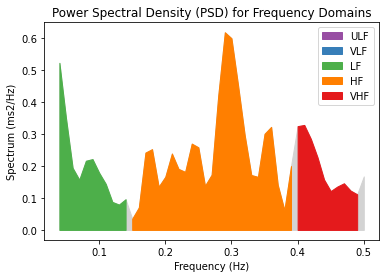

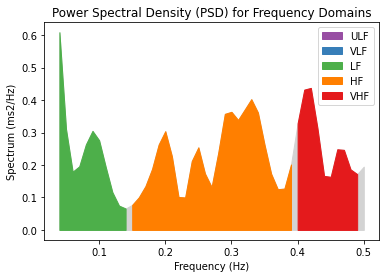

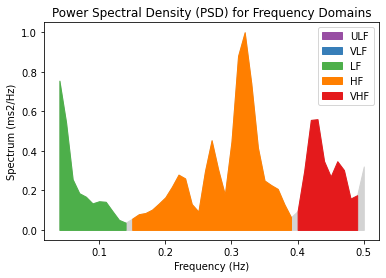

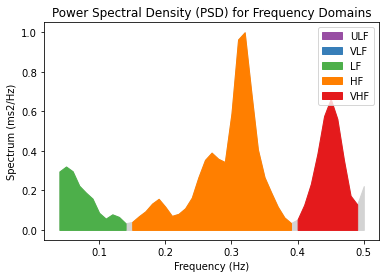

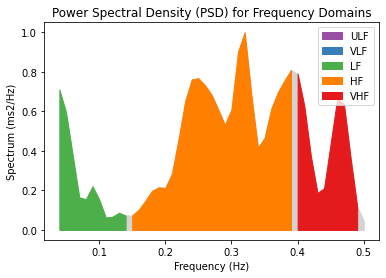

In [111]:
WINDOW_SIZE = 120
WINDOW_SHIFT = 20
BVP_SAMPLING_RATE = 64
data_path = osp.join(parser['DATA_PATH']['wesad_dataset_path'], 'WESAD_WRIST_BVP')
subject_ids = os.listdir(data_path)
for subject_id in tqdm(subject_ids):
    subject_id_folder = osp.join(data_path, subject_id)
    for file_name in os.listdir(subject_id_folder):
        file_path = osp.join(subject_id_folder, file_name)
        data = pd.read_csv(file_path)
        bvp_data = data['nanoWatt'].tolist()
        step = WINDOW_SHIFT * BVP_SAMPLING_RATE
        first_iter = WINDOW_SIZE * BVP_SAMPLING_RATE
        stats_features = []
        for current_iter in range(first_iter, len(bvp_data), step):
            previous_iter = current_iter - first_iter
            signal = bvp_data[previous_iter:current_iter]    
            bvp_stats_features = extract_bvp_features(signal, sampling_rate = BVP_SAMPLING_RATE)
            stats_features.append(bvp_stats_features)
            if np.any(np.isnan(bvp_stats_features) == True):
                print(subject_id, current_iter)
        stats_features = np.array(stats_features)